In [1]:
# Imports
import os
import yake
import sys
import collections
import string
from unidecode import unidecode
import datetime

from pprint import pprint

from collections import Counter, defaultdict
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

from IPython.display import Image

import spacy
from spacy.lang.fr.examples import sentences
nlp = spacy.load('fr_core_news_md')

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from scipy.spatial.distance import cosine

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Requête Camille : 
#
#
# -> "colonialisme OR colonie"

In [2]:
## Constantes ##
data_path = "../data"
JOURNAL_CODES = {'JB427': 'La Libre Belgique',
                 'JB1051':'Le Drapeau Rouge',
                 'JB838': 'Le Soir'}
data_files = [{'filename': os.path.join(data_path, file),
               'Journal' : JOURNAL_CODES[file.split('_')[1]],
               'Date' : datetime.datetime.strptime(file.split('_')[2], '%Y-%m-%d')}
              for file in os.listdir(data_path) 
              if 'README' not in file]
data_df = pd.DataFrame.from_dict(data_files)


In [3]:
print(data_df)

                                      filename           Journal       Date
0    ../data\KB_JB1051_1921-10-22_01-00004.txt  Le Drapeau Rouge 1921-10-22
1    ../data\KB_JB1051_1921-12-03_01-00004.txt  Le Drapeau Rouge 1921-12-03
2    ../data\KB_JB1051_1922-02-11_01-00004.txt  Le Drapeau Rouge 1922-02-11
3    ../data\KB_JB1051_1922-08-26_01-00001.txt  Le Drapeau Rouge 1922-08-26
4    ../data\KB_JB1051_1922-10-14_01-00001.txt  Le Drapeau Rouge 1922-10-14
..                                         ...               ...        ...
995   ../data\KB_JB838_1950-11-04_01-00018.txt           Le Soir 1950-11-04
996   ../data\KB_JB838_1950-11-11_01-00002.txt           Le Soir 1950-11-11
997   ../data\KB_JB838_1950-12-08_01-00016.txt           Le Soir 1950-12-08
998   ../data\KB_JB838_1950-12-30_01-00001.txt           Le Soir 1950-12-30
999   ../data\KB_JB838_1950-12-30_01-00002.txt           Le Soir 1950-12-30

[1000 rows x 3 columns]


In [4]:
# analyse de fréquence par année et par journal
print(data_df['Journal'].value_counts().to_dict())

{'La Libre Belgique': 518, 'Le Drapeau Rouge': 426, 'Le Soir': 56}


Text(0.5, 1.0, 'Distribution of documents by date')

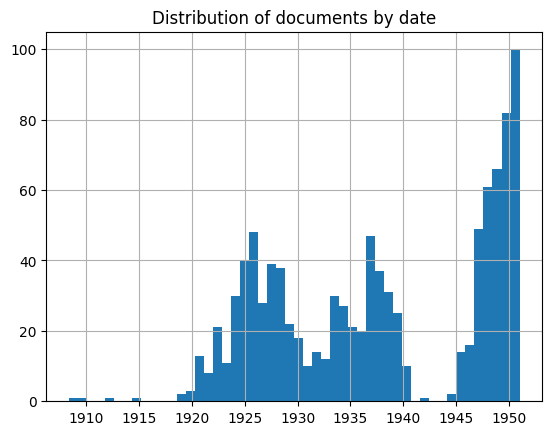

In [5]:
data_df['Date'].hist(bins=50)
plt.title('Distribution of documents by date')

Text(0.5, 1.0, 'Distribution of documents by date in Le Drapeau Rouge')

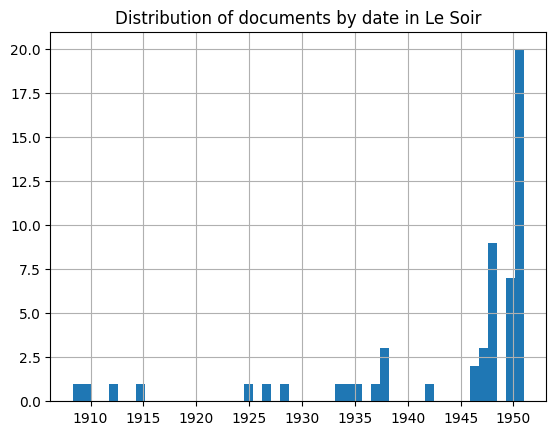

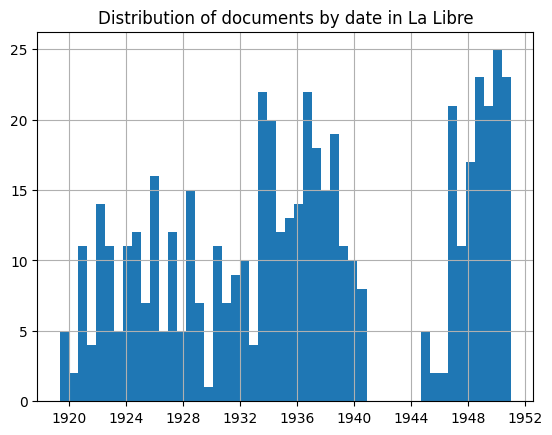

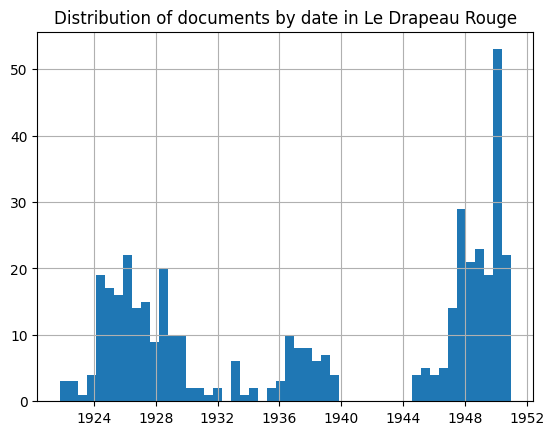

In [6]:
plt.figure()
data_df[data_df['Journal']=='Le Soir']['Date'].hist(bins=50)
plt.title('Distribution of documents by date in Le Soir')

plt.figure()
data_df[data_df['Journal']=='La Libre Belgique']['Date'].hist(bins=50)
plt.title('Distribution of documents by date in La Libre')

plt.figure()
data_df[data_df['Journal']=='Le Drapeau Rouge']['Date'].hist(bins=50)
plt.title('Distribution of documents by date in Le Drapeau Rouge')

In [7]:
# Clean text for analysis

sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville", "alors", "rossel", "vers", "avant", "tél", "rue", "déjà", "très", "des", "dès", "près", "chez", "comme", "etc",
       "car", "elles", "dés", "env","toujours", "jamais", "devant", "fois", "min", "max", "voir", "voit", "peu", "ceux", "celles", "quelque", "quelques",
       "plusieurs", "toute", "leurs", "tout","leur", "cher", "chère","bas","haut","premier","dernier", "première", "matin","soir","celui", "prés", "bruxelles", "brux", "lundi","mardi", "mercredi",
       "jeudi", "vendredi", "samedi", "dimanche", "rien"]

sw = set(sw)

def clean_text(text):
    words = nltk.wordpunct_tokenize(text)
    kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
    kept_string = " ".join(kept)
    return kept_string

tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

def get_sentiment(input_text):
    blob = tb(input_text)
    polarity, subjectivity = blob.sentiment
    polarity_perc = f"{100*abs(polarity):.0f}"
    subjectivity_perc = f"{100*subjectivity:.0f}"
    if polarity > 0:
        polarity_str = f"{polarity_perc}% positive"
    elif polarity < 0:
        polarity_str = f"{polarity_perc}% negative"
    else:
        polarity_str = "neutral"
    if subjectivity > 0:
        subjectivity_str = f"{subjectivity}% subjective"
    else:
        subjectivity_str = "perfectly objective"
    return subjectivity, polarity


In [27]:
# Keywords et Wordclouds

def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.70,
    min_df=0.01,
    # min max peut etre changé pour le travail, min est assez élévé...
    lowercase=True)

kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
subj_obj = {}
texts = {}
# Condenser par décennie et par journal
for year_start, year_stop in [(1900, 1910), (1910, 1920), (1920, 1930), (1930, 1940), (1940, 1950)]:
    for journal in JOURNAL_CODES.values():
        data = data_df[(data_df['Date'] > f"{year_start}-01-01") & 
                       (data_df['Date'] < f"{year_stop}-01-01") & 
                       (data_df['Journal'] == journal)]
        print(year_start, year_stop, journal, data.shape[0])

        if data.shape[0] == 0: continue
        
        text = []
        for _, row in data.iterrows():
            print(row['filename'])
            with open(row['filename'],'r', encoding = 'utf-8') as file:
                text.append(clean_text(file.read()))
        text = ' '.join(text)
        frequencies = Counter(text.split())
        
        print(frequencies.most_common(10))
        
        # WORDCLOUD
        cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
        cloud.to_file(f"{journal}_{year_start}_{year_stop}.png")
        
        # Named Entities
        doc = nlp(text[:900000])
        #for ent in doc.ents:
            #if ent.label_ == 'LOC':
                #print(ent)
                
        # Sentiment Analysis
        subjectivity, objectivity = get_sentiment(text[:900000])
        subj_obj[year_start, year_stop, journal] = (subjectivity, objectivity)
        
        # Embedding
        texts[year_start, year_stop, journal] = text

1900 1910 La Libre Belgique 0
1900 1910 Le Drapeau Rouge 0
1900 1910 Le Soir 2
../data\KB_JB838_1908-05-03_01-00003.txt
../data\KB_JB838_1909-03-27_01-00002.txt
[('congo', 34), ('roi', 20), ('belgique', 19), ('prince', 17), ('mars', 15), ('lèvres', 15), ('colonies', 14), ('vue', 14), ('gouvernement', 14), ('centimes', 14)]
1910 1920 La Libre Belgique 5
../data\KB_JB427_1919-05-10_01-00001.txt
../data\KB_JB427_1919-06-04_01-00002.txt
../data\KB_JB427_1919-07-15_01-00002.txt
../data\KB_JB427_1919-09-26_01-00003.txt
../data\KB_JB427_1919-10-07_01-00001.txt
[('belgique', 102), ('france', 64), ('guerre', 56), ('belge', 46), ('ans', 46), ('général', 46), ('président', 43), ('belges', 41), ('ministre', 34), ('allemagne', 33)]
1910 1920 Le Drapeau Rouge 0
1910 1920 Le Soir 2
../data\KB_JB838_1911-12-17_01-00002.txt
../data\KB_JB838_1914-07-25_01-00001.txt
[('france', 18), ('décembre', 16), ('accord', 16), ('hausse', 15), ('mois', 14), ('baromètre', 14), ('tunnel', 14), ('pays', 13), ('temps', 

Text(0.5, 1.0, 'Analyse de sentiments pour les documents, par décennie et par journal')

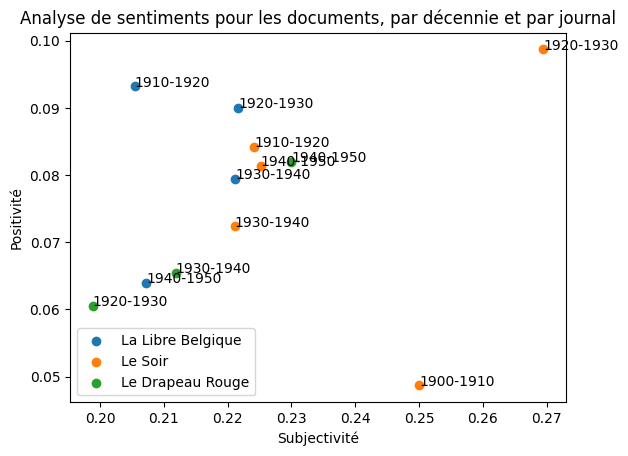

In [9]:
# sentiment et clustering / embedding + analyse keyword des cas limites
plt.figure()
plt.scatter([v[0] for k, v in subj_obj.items() if k[2] == 'La Libre Belgique'], 
         [v[1] for k, v in subj_obj.items() if k[2] == 'La Libre Belgique'])

plt.scatter([v[0] for k, v in subj_obj.items() if k[2] == 'Le Soir'], 
         [v[1] for k, v in subj_obj.items() if k[2] == 'Le Soir'])

plt.scatter([v[0] for k, v in subj_obj.items() if k[2] == 'Le Drapeau Rouge'], 
         [v[1] for k, v in subj_obj.items() if k[2] == 'Le Drapeau Rouge'])

for k, v in subj_obj.items():
    plt.annotate(f'{k[0]}-{k[1]}', v)

plt.legend(['La Libre Belgique','Le Soir','Le Drapeau Rouge'])
plt.xlabel('Subjectivité')
plt.ylabel('Positivité')
plt.title('Analyse de sentiments pour les documents, par décennie et par journal')


Text(0.5, 1.0, "Analyse de l'embedding par décennie et par journal")

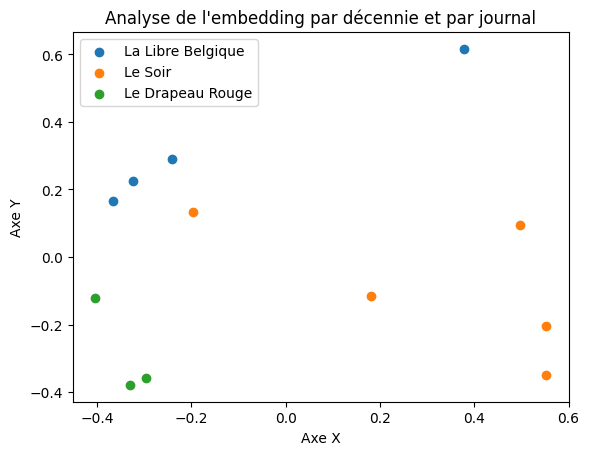

In [28]:
_texts = texts
labels = _texts.keys()
_texts = _texts.values()

tfidf_vectors = vectorizer.fit_transform(_texts)
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())
pca_data = [(label, reduced_vectors[i, :]) for i, label in enumerate(labels)]

plt.figure()
plt.scatter([v[0] for k, v in pca_data if k[2] == 'La Libre Belgique'], 
         [v[1] for k, v in pca_data if k[2] == 'La Libre Belgique'])
plt.scatter([v[0] for k, v in pca_data if k[2] == 'Le Soir'], 
         [v[1] for k, v in pca_data if k[2] == 'Le Soir'])
plt.scatter([v[0] for k, v in pca_data if k[2] == 'Le Drapeau Rouge'], 
         [v[1] for k, v in pca_data if k[2] == 'Le Drapeau Rouge'])

#for k, v in pca_data:
#    plt.annotate(f'{k[0]}-{k[1]}', v)

plt.legend(['La Libre Belgique','Le Soir','Le Drapeau Rouge'])
plt.xlabel('Axe X')
plt.ylabel('Axe Y')
plt.title('Analyse de l\'embedding par décennie et par journal')
